In [28]:
import ete3
import random
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import os
import subprocess
from itertools import product, combinations
import community
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor as hr, LinearRegression as lr

In [2]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [3]:
random.seed(12345)
fixed_tree = ete3.Tree()
tree_size  = 50
taxa       = []
loop_count = 0
while len(taxa) < tree_size:
    if tree_size <= 25:
        for chr_number in range(97, 97+tree_size):
            taxa.append(chr(chr_number))
    else:
        loop_count += 1
        for chr_number in range(97, 123):
            taxa.append('%s%i' %(chr(chr_number), loop_count))
        taxa = taxa[:tree_size]
            
#taxa = set(taxa)
fixed_tree.populate(size=tree_size, names_library=taxa, random_branches=True)
for node in fixed_tree.traverse():
    node.img_style["size"] = 0
fixed_tree.dist = 0.1
print(fixed_tree)


               /-y1
            /-|
           |   \-x1
           |
           |      /-w1
         /-|   /-|
        |  |  |  |   /-v1
        |  |  |   \-|
        |  |  |      \-u1
        |  |  |
        |   \-|      /-t1
        |     |   /-|
        |     |  |   \-s1
        |     |  |
        |     |  |      /-r1
        |      \-|   /-|
        |        |  |  |   /-q1
        |        |  |   \-|
        |        |  |     |   /-p1
        |         \-|      \-|
      /-|           |         \-o1
     |  |           |
     |  |           |   /-n1
     |  |            \-|
     |  |               \-m1
     |  |
     |  |         /-l1
     |  |      /-|
     |  |     |  |   /-k1
     |  |     |   \-|
     |  |   /-|      \-j1
     |  |  |  |
     |  |  |  |   /-i1
     |  |  |   \-|
     |  |  |      \-h1
     |   \-|
     |     |      /-g1
     |     |   /-|
     |     |  |   \-f1
     |     |  |
     |     |  |      /-e1
     |      \-|   /-|
     |        |  |  |   /-d1
   /-| 

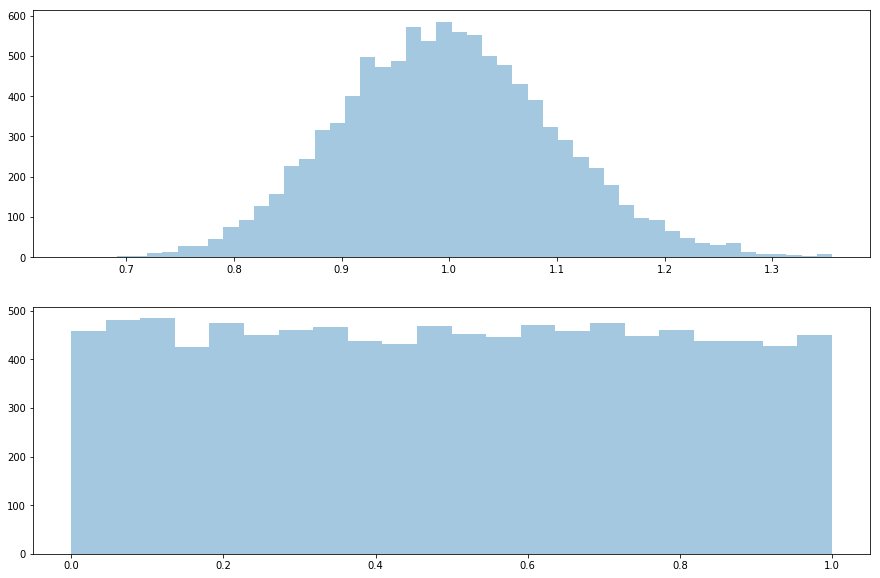

In [4]:
with pm.Model() as model:
    alpha = 1/np.mean([node.dist for node in fixed_tree.traverse()
                       if not node.is_root()])
    br_length_scale   = pm.Gamma('br_length_scale', 100, 100)
    point_of_transfer = pm.Uniform('point_of_transfer', lower=0, upper=1)

fig, axs = plt.subplots(figsize=(15, 10), nrows=2)
sample   = br_length_scale.random(size=10000)
sns.distplot(sample, kde=False, ax=axs[0])
sample   = point_of_transfer.random(size=10000)
sns.distplot(sample, kde=False, ax=axs[1])

In [6]:
ts = ete3.TreeStyle()
ts.show_branch_length = True

np.random.seed(12345)
random.seed(12345)
tree         = fixed_tree.copy()
topologies   = [tree.copy()]
topology_ids = set(tree.get_topology_id())
tree.render(file_name="tree_%i.png" % len(topologies), dpi=100, w=500, units='px', tree_style=ts)
while len(topologies) < 10:
    starting_tree = tree.copy()
    
    pruned_node    = random.choice([node for node in tree.traverse()
                                    if tree.get_distance(node, topology_only=True) > 0]).copy()
    pruned_node.dist *= br_length_scale.random()
    
    tree.prune(set(taxa).difference(pruned_node.get_leaf_names()), preserve_branch_length=True)

    source = random.choice([node for node in tree.traverse()
                            if not node.is_root()])

    source.add_sister(pruned_node)
    tree.resolve_polytomy()

    topology_id = tree.get_topology_id()
    if topology_id in topology_ids:
        tree = starting_tree.copy()
        continue
    
    if pruned_node.is_leaf():
        recipient = tree.get_leaves_by_name(pruned_node.name)[0]
    else:
        recipient = tree.get_common_ancestor(pruned_node.get_leaf_names())
    parent    = recipient.get_ancestors()[0]
    donor     = recipient.get_sisters()[0]

    proportion  = point_of_transfer.random()
    parent.dist = donor.dist * proportion
    donor.dist -= donor.get_ancestors()[0].dist

    parent.img_style['size']       = 0
    donor.img_style['size'   ]     = 5
    donor.img_style['fgcolor']     = 'red'
    recipient.img_style['size'   ] = 5
    recipient.img_style['fgcolor'] = 'blue'
    
    topology_ids.add(topology_id)
    topologies.append(tree.copy())
    tree.render(file_name="tree_%i.png" % len(topologies), dpi=100, w=500, units='px', tree_style=ts)

    donor.img_style['size']        = 0
    recipient.img_style['size']    = 0

In [7]:
indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - site-rate project                               //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   12345

[MODEL] model1   [submodel]  LG                         //   LG
                 [rates]     0 0.8025 12                //   pinv=0, alpha=1.3, discrete gamma categories=20
                 [statefreq]
                    0.0790   0.0843   0.0346   0.0392   // list of 20 numbers
                    0.0055   0.0293   0.0535   0.0956   // A R N D C
                    0.0217   0.0704   0.0699   0.1008   // Q E G H I
                    0.0253   0.0280   0.0415   0.0519   // L K M F P
                    0.0516   0.0065   0.0217   0.0898   // S T W Y V
                 [indelmodel]   POW  1.7 500 // Power law insertion/deletion length distribution (a=1.7)
                 [indelrate]    0.1
'''

indelible_tree_exert      = '[TREE]       {tree_name}  {newick}\n'
indelible_partition_exert = '[PARTITIONS] {partition_name} [{tree_name} model1 1000]\n'
indelible_evolve_exert    = '             {partition_name}  1   {tree_name}\n'

for count, tree in enumerate(topologies):
    indelible_conf += indelible_tree_exert.format(tree_name='tree_%i'  % count,
                                                  newick   = tree.write(format=5, dist_formatter='%.10f'))
indelible_conf += '\n'
    
for count, tree in enumerate(topologies):
    indelible_conf += indelible_partition_exert.format(partition_name='partition_%i'  % count,
                                                       tree_name     ='tree_%i'       % count)
indelible_conf += '\n'

indelible_conf += '[EVOLVE]     {partition_name}  1   {tree_name}\n'.format(
    partition_name='partition_0',
    tree_name     ='tree_0')
for count, tree in enumerate(topologies[1:], 1):
    indelible_conf += indelible_evolve_exert.format(partition_name='partition_%i'  % count,
                                                    tree_name     ='tree_%i'       % count)

out = open('control.txt', 'w')
out.write(indelible_conf)
out.close()

#print(indelible_conf)

In [80]:
for count, tree in enumerate(topologies):
    tree.write(outfile='trees/tree_%i.nwk' % count, format=5, dist_formatter='%.10f')
    shutil.copy('tree_%i_True.phy' % count, 'alignments/tree_%i.phy' % count)

In [81]:
geodesic_dists = pd.read_csv('geodesic_distances.tab', sep='\t', index_col=0)
rf_dists       = pd.read_csv(      'rf_distances.tab', sep='\t', index_col=0)

In [78]:
geodesic_dists

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,3.317818,3.431769,3.724193,4.439473,5.466732,5.562140,5.570878,5.643612,5.666962
tree_1,3.317818,0.000000,0.878623,1.692500,4.277106,5.333474,5.430994,5.440060,5.515275,5.549634
tree_2,3.431769,0.878623,0.000000,1.446575,4.203000,5.367143,5.466444,5.475450,5.595558,5.627579
tree_3,3.724193,1.692500,1.446575,0.000000,3.946218,5.446412,5.493022,5.502451,5.625078,5.669529
tree_4,4.439473,4.277106,4.203000,3.946218,0.000000,4.361127,4.382671,4.691413,5.503283,5.502678
tree_5,5.466732,5.333474,5.367143,5.446412,4.361127,0.000000,3.579688,4.312557,5.184102,5.183460
tree_6,5.562140,5.430994,5.466444,5.493022,4.382671,3.579688,0.000000,3.501616,4.508333,5.009769
tree_7,5.570878,5.440060,5.475450,5.502451,4.691413,4.312557,3.501616,0.000000,3.291541,3.941461
tree_8,5.643612,5.515275,5.595558,5.625078,5.503283,5.184102,4.508333,3.291541,0.000000,3.770473
tree_9,5.666962,5.549634,5.627579,5.669529,5.502678,5.183460,5.009769,3.941461,3.770473,0.000000


In [8]:
spr_distances  = pd.DataFrame(index  =['tree_%i' % num for num in range(len(topologies))],
                              columns=['tree_%i' % num for num in range(len(topologies))],
                              data=[abs(np.arange(10)-n) for n in range(10)])
spr_distances

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0,1,2,3,4,5,6,7,8,9
tree_1,1,0,1,2,3,4,5,6,7,8
tree_2,2,1,0,1,2,3,4,5,6,7
tree_3,3,2,1,0,1,2,3,4,5,6
tree_4,4,3,2,1,0,1,2,3,4,5
tree_5,5,4,3,2,1,0,1,2,3,4
tree_6,6,5,4,3,2,1,0,1,2,3
tree_7,7,6,5,4,3,2,1,0,1,2
tree_8,8,7,6,5,4,3,2,1,0,1
tree_9,9,8,7,6,5,4,3,2,1,0


In [23]:
distance_matrices = {}
for count, tree in enumerate(topologies):
    patristic_distances = []
    for taxon1, taxon2 in combinations(taxa, 2):
        patristic_distances.append(tree.get_distance(taxon1, taxon2))
    distance_matrices['tree_%i' % count] = pd.DataFrame(index=taxa, 
                                                        columns=taxa, 
                                                        data=squareform(patristic_distances))

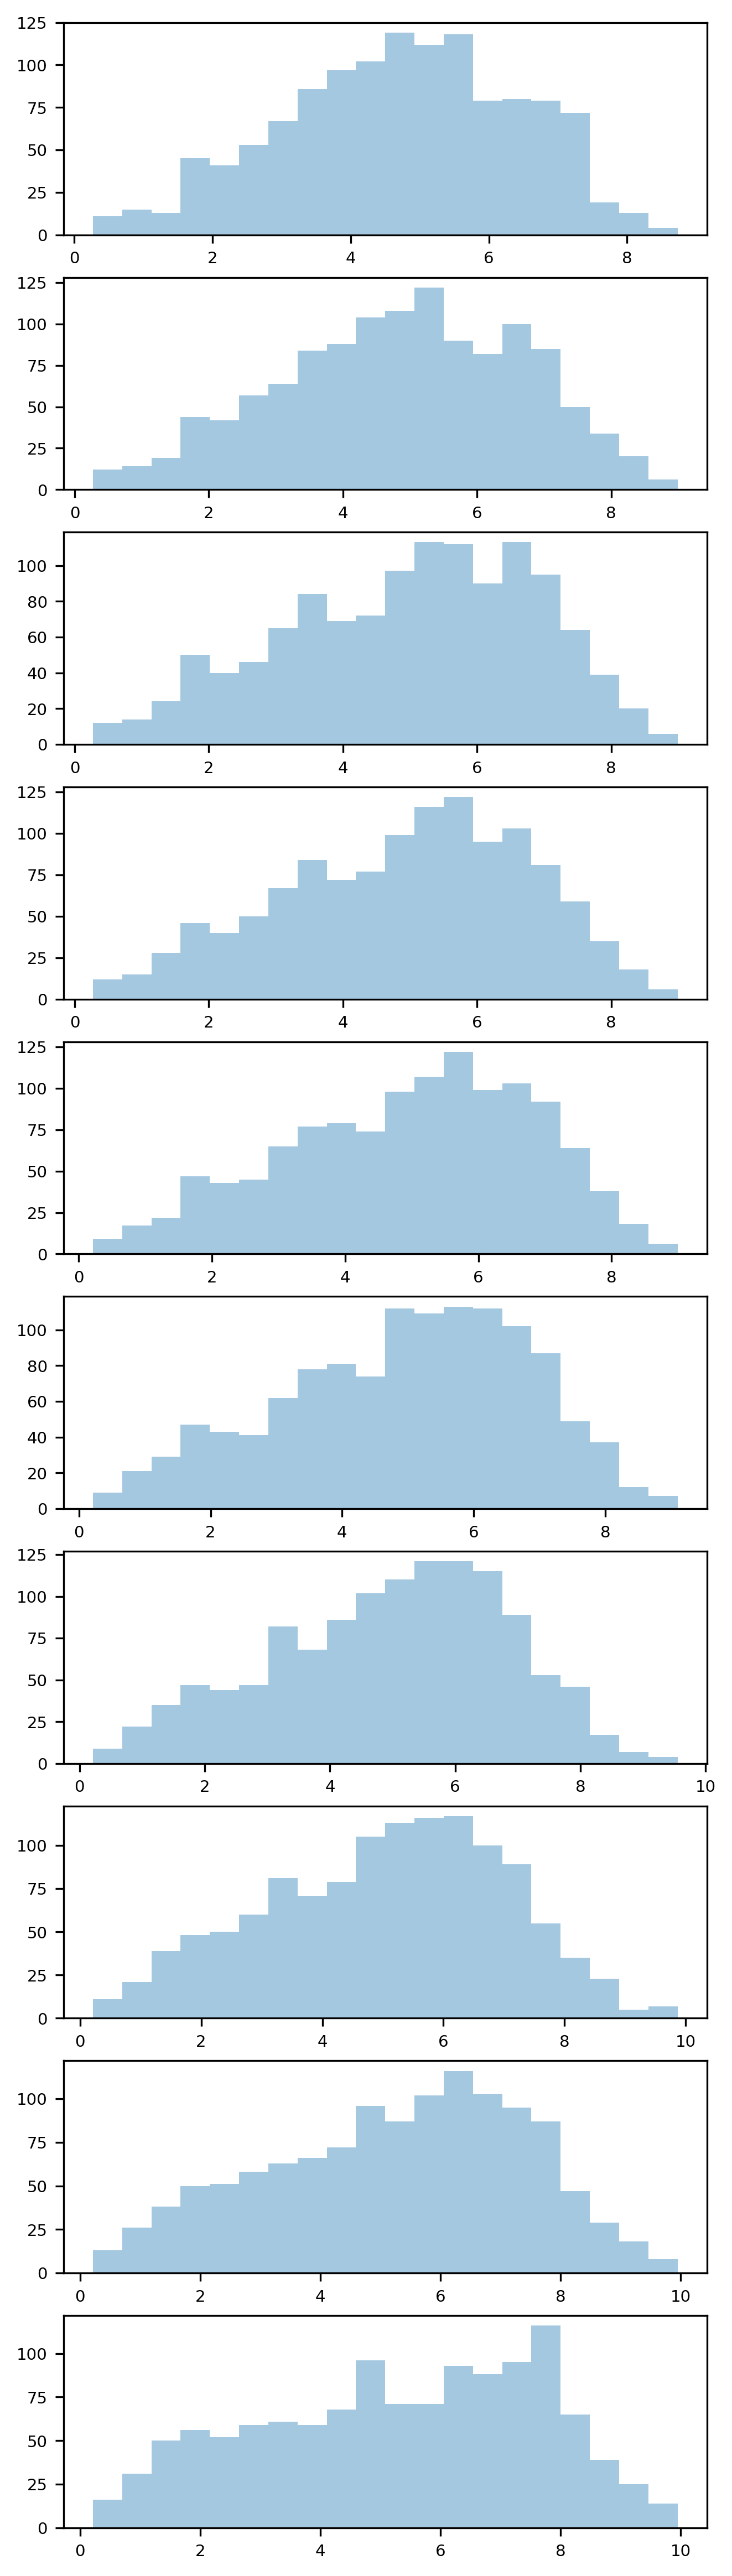

In [25]:
plt.rcParams.update({'font.size': 7})
fig, ax = plt.subplots(figsize=(5,20), dpi=300, nrows=len(distance_matrices))
family_clusters = {}
for num in range(len(topologies)):
    df = distance_matrices['tree_%i' % num]
    sns.distplot(squareform(df.values), kde=False, ax=ax[num], bins=20)

In [27]:
family_corrs = []
for family1, family2 in combinations(distance_matrices.keys(), 2):
    family_corrs.append(
        pearsonr(
            squareform(distance_matrices[family1].values),
            squareform(distance_matrices[family2].values)
    )[0])
family_corrs = pd.DataFrame(index  =distance_matrices.keys(),
                            columns=distance_matrices.keys(),
                            data=squareform(family_corrs))
family_corrs

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,0.899267,0.896073,0.880154,0.830141,0.692437,0.664924,0.581284,0.460896,0.391645
tree_1,0.899267,0.000000,0.986419,0.973616,0.915359,0.786838,0.760906,0.674315,0.519058,0.421347
tree_2,0.896073,0.986419,0.000000,0.988326,0.931548,0.808087,0.783264,0.694609,0.556353,0.453941
tree_3,0.880154,0.973616,0.988326,0.000000,0.940905,0.820980,0.798145,0.708023,0.567311,0.465131
tree_4,0.830141,0.915359,0.931548,0.940905,0.000000,0.881302,0.859067,0.762988,0.612363,0.488497
tree_5,0.692437,0.786838,0.808087,0.820980,0.881302,0.000000,0.965409,0.863468,0.708352,0.596078
tree_6,0.664924,0.760906,0.783264,0.798145,0.859067,0.965409,0.000000,0.895749,0.740026,0.632712
tree_7,0.581284,0.674315,0.694609,0.708023,0.762988,0.863468,0.895749,0.000000,0.844412,0.736013
tree_8,0.460896,0.519058,0.556353,0.567311,0.612363,0.708352,0.740026,0.844412,0.000000,0.848404
tree_9,0.391645,0.421347,0.453941,0.465131,0.488497,0.596078,0.632712,0.736013,0.848404,0.000000


In [56]:
pearsonr(squareform(spr_distances), squareform(family_corrs))

(-0.8871050379823713, 4.945934032718618e-16)

In [29]:
def huber_loss(residuals, epsilon=1.35):
    # https://en.wikipedia.org/wiki/Huber_loss
    corrected_residuals = []
    for error in residuals:
        if abs(error) <= epsilon:
            corrected_residuals.append((error**2)/2)
        else:
            corrected_residuals.append(epsilon*(abs(error)-epsilon/2))
    return(np.mean(corrected_residuals))

In [139]:
least_square = []
for family1, family2 in combinations(distance_matrices.keys(), 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)
    X = X.reshape(-1, 1)
    regression = lr(fit_intercept=False).fit(X, Y)

    pred_y = regression.predict(X)
    least_square.append(sum((pred_y-Y)**2))

least_square = pd.DataFrame(index  =distance_matrices.keys(),
                            columns=distance_matrices.keys(),
                            data=squareform(least_square))
least_square

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,780.692290,854.622425,959.079636,1371.994943,2477.693211,2720.726373,3647.487590,5302.426539,6676.172460
tree_1,780.692290,0.000000,114.693863,216.796811,701.920664,1764.960175,1995.457962,2913.948963,4843.587420,6476.734848
tree_2,854.622425,114.693863,0.000000,96.593421,572.304672,1602.240117,1823.902718,2753.603424,4508.716632,6165.681215
tree_3,959.079636,216.796811,96.593421,0.000000,494.932322,1497.441936,1702.127313,2637.884631,4405.421199,6051.539020
tree_4,1371.994943,701.920664,572.304672,494.932322,0.000000,996.069438,1192.419945,2149.522327,3959.874482,5799.328107
tree_5,2477.693211,1764.960175,1602.240117,1497.441936,996.069438,0.000000,297.504848,1259.286351,3029.080241,4670.651750
tree_6,2720.726373,1995.457962,1823.902718,1702.127313,1192.419945,297.504848,0.000000,967.626531,2716.749274,4278.795574
tree_7,3647.487590,2913.948963,2753.603424,2637.884631,2149.522327,1259.286351,967.626531,0.000000,1678.716115,3176.183611
tree_8,5302.426539,4843.587420,4508.716632,4405.421199,3959.874482,3029.080241,2716.749274,1678.716115,0.000000,1889.161575
tree_9,6676.172460,6476.734848,6165.681215,6051.539020,5799.328107,4670.651750,4278.795574,3176.183611,1889.161575,0.000000


In [141]:
regression.score(X.reshape(-1, 1), Y)

0.7141077895247333

In [55]:
pearsonr(squareform(spr_distances), squareform(least_square))

(0.8246629839441805, 3.3165145006685224e-12)

In [159]:
huber = []
huber_thresh = 1.35
loss_yx = 999999999
for family1, family2 in combinations(distance_matrices.keys(), 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)
    
    regression = hr(epsilon=huber_thresh, fit_intercept=False).fit(X.reshape(-1, 1), Y)
    pred_y     = regression.predict(X.reshape(-1, 1))
    loss_xy    = huber_loss(Y-pred_y)
    huber.append(loss_xy)

huber = pd.DataFrame(index  =distance_matrices.keys(),
                     columns=distance_matrices.keys(),
                     data=squareform(huber))
huber

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9
tree_0,0.000000,0.224404,0.277882,0.306880,0.401900,0.619770,0.680926,0.902093,1.313151,1.555180
tree_1,0.224404,0.000000,0.054261,0.089303,0.195953,0.412971,0.477258,0.702658,1.165173,1.456203
tree_2,0.277882,0.054261,0.000000,0.042555,0.145229,0.360009,0.421232,0.647847,1.084546,1.391187
tree_3,0.306880,0.089303,0.042555,0.000000,0.105872,0.316406,0.376213,0.608620,1.058109,1.406648
tree_4,0.401900,0.195953,0.145229,0.105872,0.000000,0.209831,0.268975,0.505211,0.961785,1.354317
tree_5,0.619770,0.412971,0.360009,0.316406,0.209831,0.000000,0.075042,0.312950,0.766819,1.150489
tree_6,0.680926,0.477258,0.421232,0.376213,0.268975,0.075042,0.000000,0.240443,0.691660,1.071615
tree_7,0.902093,0.702658,0.647847,0.608620,0.505211,0.312950,0.240443,0.000000,0.445266,0.820068
tree_8,1.313151,1.165173,1.084546,1.058109,0.961785,0.766819,0.691660,0.445266,0.000000,0.447189
tree_9,1.555180,1.456203,1.391187,1.406648,1.354317,1.150489,1.071615,0.820068,0.447189,0.000000


In [143]:
from sklearn.linear_model import SGDRegressor as sgd

In [162]:
huber2 = sgd(loss='huber', epsilon=1.35, fit_intercept=False).fit(X.reshape(-1, 1), Y)

In [177]:
huber2.partial_fit?

In [171]:
regression.score(X.reshape(-1, 1), Y)

0.7140509427115957

In [54]:
pearsonr(squareform(spr_distances), squareform(huber))

(0.8212083981720174, 4.86268850487983e-12)

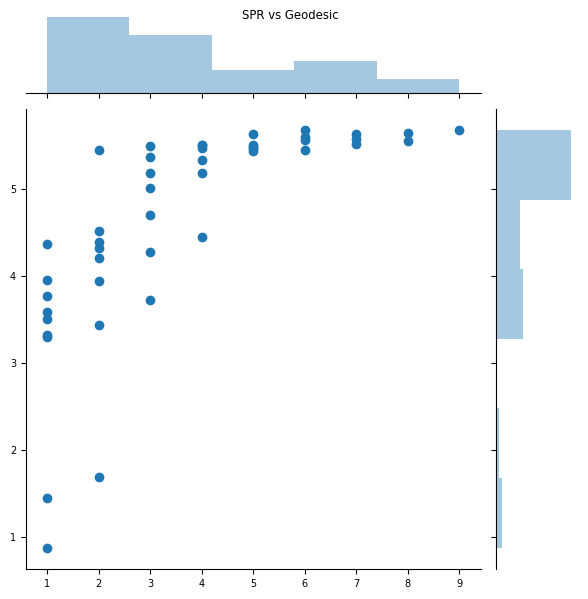

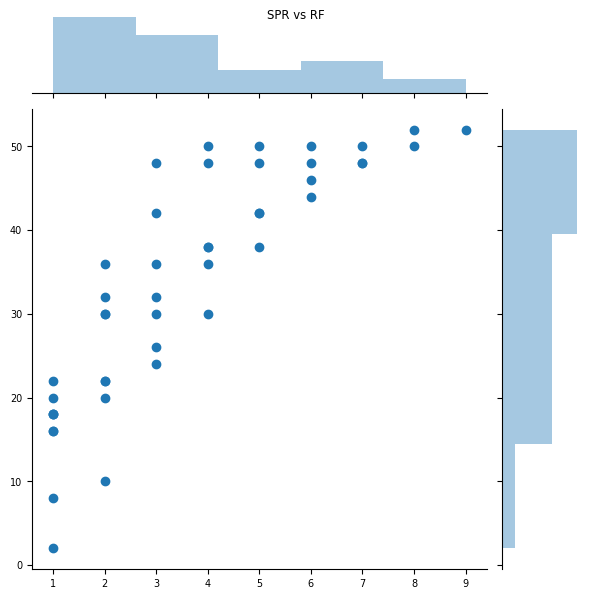

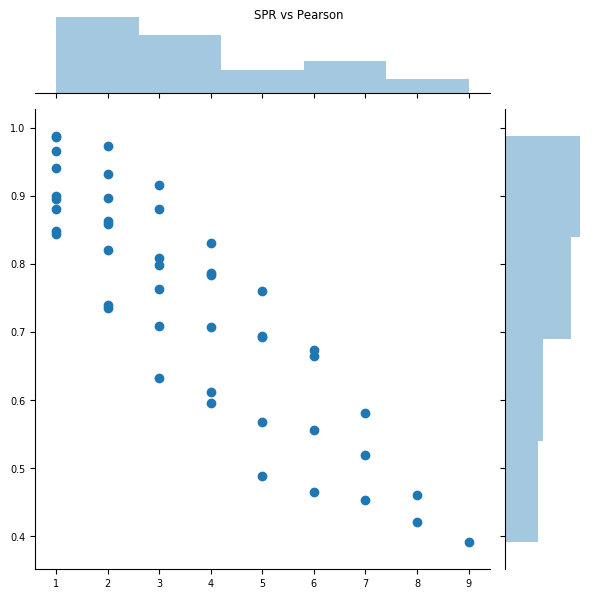

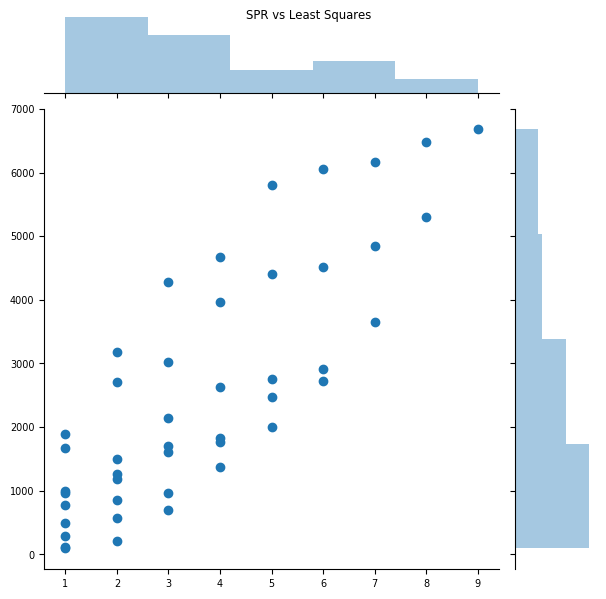

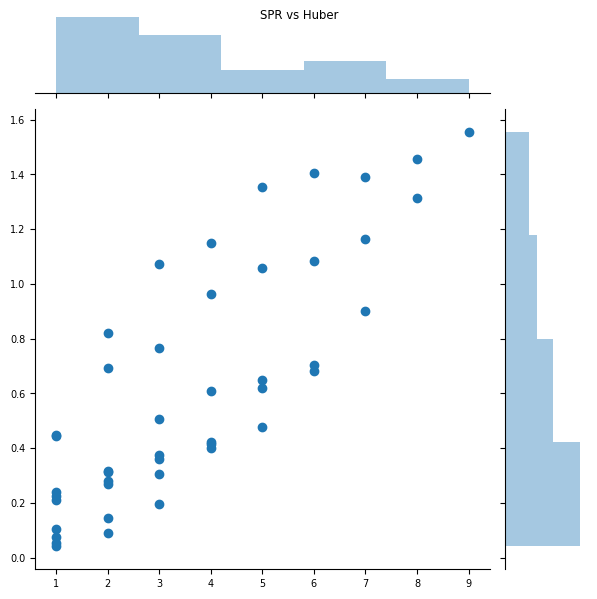

In [82]:
plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(geodesic_dists))
plot.fig.suptitle('SPR vs Geodesic')
plot.fig.set_dpi(100)

plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(rf_dists))
plot.fig.suptitle('SPR vs RF')
plot.fig.set_dpi(100)

plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(family_corrs))
plot.fig.suptitle('SPR vs Pearson')
plot.fig.set_dpi(100)

plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(least_square))
plot.fig.suptitle('SPR vs Least Squares')
plot.fig.set_dpi(100)

plot = sns.jointplot(x=squareform(spr_distances),
                     y=squareform(huber))
plot.fig.suptitle('SPR vs Huber')
plot.fig.set_dpi(100)

In [83]:
######################## statsmodels
import statsmodels.api as sm

In [179]:
for family1, family2 in combinations(distance_matrices.keys(), 2):
    X = squareform(distance_matrices[family1].values)
    Y = squareform(distance_matrices[family2].values)
    break
least_squares_alt = sm.OLS(Y, X)
res = least_squares_alt.fit()
print(res.bse)
res.summary()

[0.00455462]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                          5.081e+04
Date:                Tue, 01 Oct 2019   Prob (F-statistic):                        0.00
Time:                        17:57:43   Log-Likelihood:                         -1462.3
No. Observations:                1225   AIC:                                      2927.
Df Residuals:                    1224   BIC:                                      2932.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0267      0.005    225.411      0.000       1.018       1.036
==============================================================================
Omnibus:                      665.263   Durbin-Watson:                   0.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7606.798
Skew:                           2.271   Prob(JB):                         0.00
Kurtosis:                      14.332   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
res.aic

2926.518475330261

In [182]:
huber_alt = sm.RLM(Y, X, M=sm.robust.norms.HuberT())
res       = huber_alt.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                 1225
Model:                            RLM   Df Residuals:                     1224
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2019                                         
Time:                        17:58:06                                         
No. Iterations:                    18                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000    5.6e-18   1.79e+17      0.000       1.000       1.000
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

In [115]:
huber_alt.weights.sum()

1128.9675499113953

In [183]:
res.aic

AttributeError: 'RLMResults' object has no attribute 'aic'